In [195]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC # "Support vector classifier"


## Open MNIST data and create a subset with desired digits

<font color=red>Change the code below to select a different subset </font>

In [196]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

with open('temp.pickle', 'wb') as handle:
    pickle.dump([X, y], handle)

In [197]:

def loadData(digits = (0,1)):
    # loading the temporary variables for fast retrieval
    with open('temp.pickle', 'rb') as handle:
        X, y = pickle.load(handle)
        
    indices = y==digits[0]
    for i in digits:
        indices = indices | (y==i)

    Xnew = X[indices]
    ynew = y[indices]
    #ynew = 0*digit1index[index]+digit2index[index]
    Nfeatures = np.size(Xnew,1)
    Nsamples = np.size(Xnew,0)

    X_train, X_test, y_train, y_test = train_test_split(Xnew, ynew, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1) # 0.25 x 0.8 = 0.2

    Nsamples = X_train.shape[0]
    Nfeatures = X_train.shape[1]

    return X_train, y_train, X_test, y_test, X_val, y_val

X_train, y_train, X_test, y_test, X_val, y_val = loadData((0,1))
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(10346, 784) (1478, 784) (2956, 784)
(10346,) (1478,) (2956,)


## General Utility

In [198]:
def countMisclassifications(model, x_data, y_data):
    count = 0
    predicted = model.decision_function(x_data)
    for i, y_compare in enumerate(y_data):
        if y_compare == 0 and predicted[i] > 0:
            count += 1
        elif y_compare == 1 and predicted[i] < 0:
            count += 1
    return count

def plotGrid(data, title):
    dim = math.ceil(len(data) ** (1/2))
    rows = dim
    if ((dim*dim) - len(data)) == dim:
        rows -= 1

    fig, axs = plt.subplots(rows, dim)
    for i, grid in enumerate(data):
        row = math.floor(i/dim)
        col = i % dim
        axs[row, col].imshow(np.reshape(grid,(28,28)))
        axs[row,col].get_xaxis().set_visible(False)
        axs[row,col].get_yaxis().set_visible(False)
    
    fig.suptitle(title)
    return fig

## Two Class Classification with Linear Classifier

Found 76 support vectors!


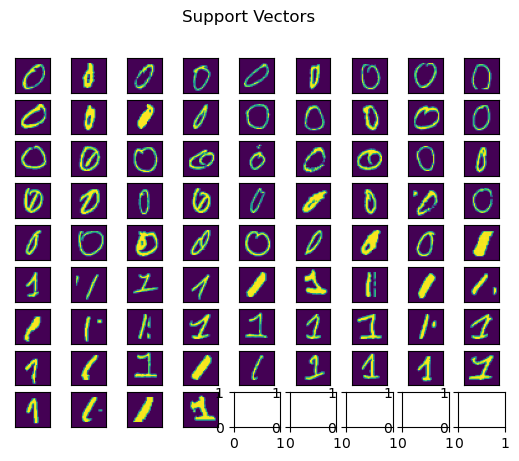

In [199]:
# Plotting the support vectors
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
sv = clf.support_vectors_
print(f"Found {len(sv)} support vectors!")

fig = plotGrid(sv, 'Support Vectors')


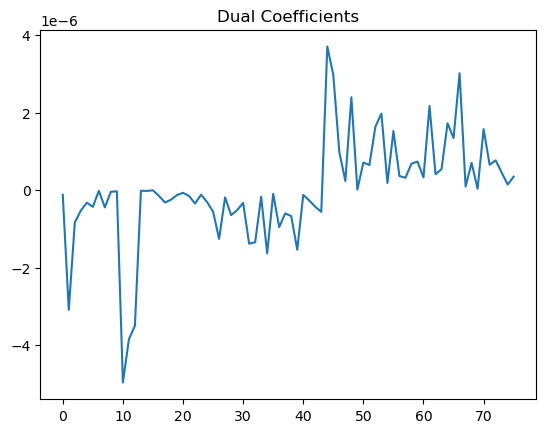

In [200]:
# Plotting the dual coefficients
dc = clf.dual_coef_
plt.title('Dual Coefficients')
fig = plt.plot(dc[0])

### Dual Coefficients Plot Explained
We can see from the plots above the dual cofficients class that about the first half of images represent that zero digit at the second half of digits represent the 1 digit. This is reflected in our dual coefficients as well which is why half the plot is mostly >1 and the half before is <0. The coefficients represent the weight of the support vector, so the weights associated with the 1's are on average > 0 as would be expected.

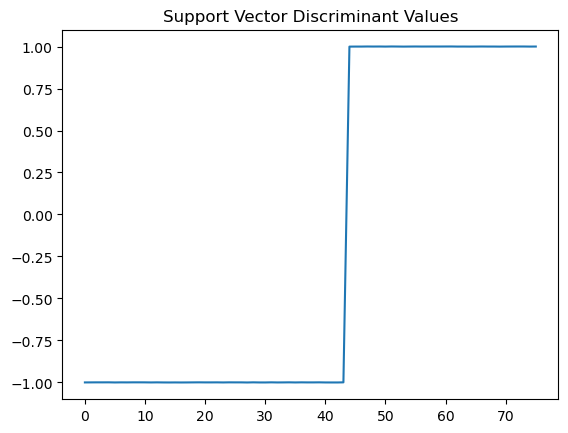

In [201]:
sv_predict = clf.decision_function(sv)
plt.title('Support Vector Discriminant Values')
fig = plt.plot(sv_predict)

### Explaining Discriminant Values

Same as mentioned above regarding the dual coefficients, while not perfect the discriminant seems to be correctly classifying most of the support vectors where the 0's are getting a negative value and 1's are getting a positive based on the discriminant output.

Wnot = 1.2978894737208817


/var/folders/ss/k7gynnys5032l09n_v3zc_cm0000gn/T/ipykernel_66994/1737986988.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  wnot = clf.intercept_[0]/clf.coef_[0][1]


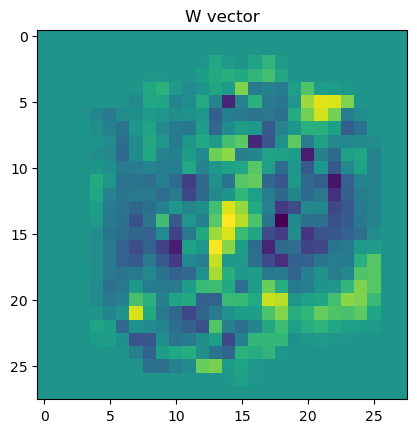

In [202]:
W = clf.coef_
plt.title('W vector')
fig = plt.imshow(np.reshape(W,(28,28)))
wnot = clf.intercept_[0]/clf.coef_[0][1]
print(f"Wnot = {clf.intercept_[0]}")

New number of support vectors with C = 1e-8 is 508


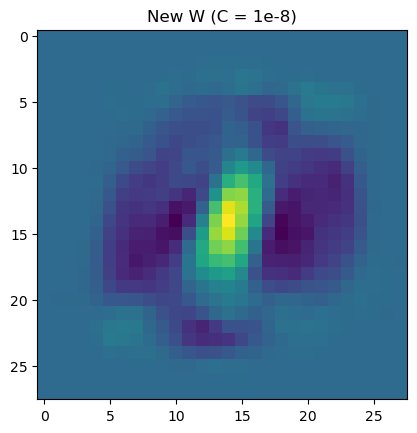

In [203]:
# Plotting the support vectors
clf_lower_C = SVC(C=1e-8, kernel='linear')
clf_lower_C.fit(X_train, y_train)

print(f"New number of support vectors with C = 1e-8 is {len(clf_lower_C.support_vectors_)}")
W_lower_c = clf_lower_C.coef_
plt.title('New W (C = 1e-8)')
fig = plt.imshow(np.reshape(W_lower_c,(28,28)))

### Explanation of increase in support vectors and new W
C in some sorts is a penalty for the "slack", any pattern will violate this as it exceeds the value. As you INCREASE C, you are raising this "acceptable" threshold meaning less support vectors will be captured. When you lower C (as we have done here since the default value is 1) you are making it more difficult and therefore increasing the number of support vectors, aka vectors that don't meet our criteria.

In [204]:
# Use the regularization parameter (C) to optimize the function for the validation data
optimal = None
lowest_misclass = None
for i in np.linspace(5e-5, 10e-7, 100):
    test = SVC(C=i, kernel='linear')
    test.fit(X_train, y_train)
    misclass = countMisclassifications(test, X_val, y_val)

    if lowest_misclass == None or misclass < lowest_misclass:
        optimal = i
        lowest_misclass = misclass

print(f"Lowest misclassification achieved was {lowest_misclass} misclassifcations on the validation data set.")
print(f"This was acheived with a regularization parameter set to {optimal}")

Lowest misclassification achieved was 1 misclassifcations on the validation data set.
This was acheived with a regularization parameter set to 1e-06


In [205]:
# Digits 0-1:
X_train, y_train, X_test, y_test, X_val, y_val = loadData((0,1))

optimal_clf = SVC(C=optimal, kernel='linear')
optimal_clf.fit(X_train, y_train)

score = optimal_clf.score(X_test, y_test)
print(f"For digits 0,1: Optimal C = {optimal} scored {score}")

# Digits 2-3:
X_train, y_train, X_test, y_test, X_val, y_val = loadData((2,3))

optimal_clf = SVC(C=optimal, kernel='linear')
optimal_clf.fit(X_train, y_train)

score = optimal_clf.score(X_test, y_test)
print(f"For digits 2,3: Optimal C = {optimal} scored {score}")

For digits 0,1: Optimal C = 1e-06 scored 0.9993234100135318
For digits 2,3: Optimal C = 1e-06 scored 0.9748850371418465


## Multi-class Classification

In [206]:
digits = (0,1,2)
X_train, y_train, X_test, y_test, X_val, y_val = loadData(digits)

In [207]:
def build_classifier(x_data, y_data, C=1.0, kernel='linear', degree=3, gamma='scale', shape='ovr'):
    classifier = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, decision_function_shape=shape)
    classifier.fit(x_data, y_data)
    return classifier

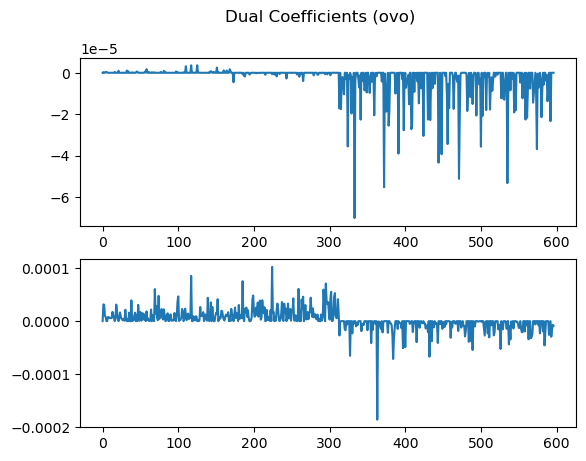

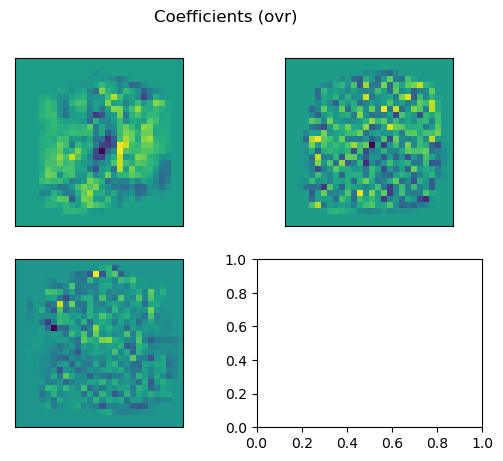

In [208]:
# OVR
classifier = build_classifier(X_train, y_train, shape='ovr')
dual_coef = classifier.dual_coef_

fig1, axs = plt.subplots(len(dual_coef))
for i, dc in enumerate(dual_coef):
    axs[i].plot(dc)
fig1.suptitle('Dual Coefficients (ovo)')

fig2 = plotGrid(classifier.coef_, 'Coefficients (ovr)')

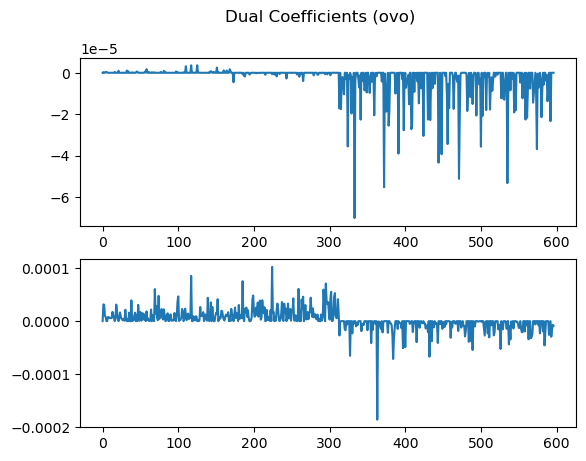

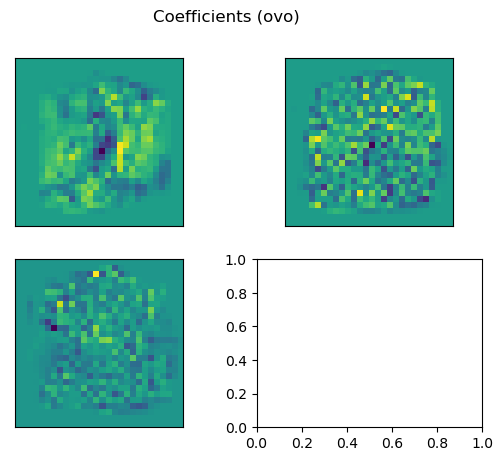

In [209]:
# OVO
classifier = build_classifier(X_train, y_train, shape='ovo')
dual_coef = classifier.dual_coef_

fig1, axs = plt.subplots(len(dual_coef))
for i, dc in enumerate(dual_coef):
    axs[i].plot(dc)
fig1.suptitle('Dual Coefficients (ovo)')

fig2 = plotGrid(classifier.coef_, 'Coefficients (ovo)')

In [219]:
shape_options = ['ovr', 'ovo']
C_options = [1e-6]
degree_options = [1]
kernel_options = ['linear', 'rbf', 'sigmoid']
gamma_options = ['scale', 'auto']

def bruteForceTest():
    best = None
    high_score = None

    for shape in shape_options:
        for degree in degree_options:
            for kernel in kernel_options:
                for gamma in gamma_options:
                    for C in C_options:
                        test = {
                            'shape': shape,
                            'degree': degree,
                            'kernel': kernel,
                            'gamma': gamma,
                            'C': C,
                        }

                        svr_test = build_classifier(X_train, y_train, C=C, kernel=kernel, degree=degree, gamma=gamma, shape=shape)
                        test_score = svr_test.score(X_test, y_test)

                        if best == None or test_score > high_score:
                            print(f"Achieved new high score ({test_score}) with: {test}")
                            high_score = test_score
                            best = test
    
    return best, high_score

best, high_score = bruteForceTest()
print(f"Best results (score = {high_score}) achieved with:")
print(best)


Achieved new high score (0.989664676159853) with: {'shape': 'ovr', 'degree': 1, 'kernel': 'linear', 'gamma': 'scale', 'C': 1e-06}
Best results (score = 0.989664676159853) achieved with:
{'shape': 'ovr', 'degree': 1, 'kernel': 'linear', 'gamma': 'scale', 'C': 1e-06}


Best so far: Achieved new high score (0.9901240238860818) with: {'shape': 'ovr', 'degree': 0.0, 'kernel': 'linear', 'gamma': 'scale', 'C': 1.9999999999999944e-06}
Poly best: {'shape': 'ovr', 'degree': 2, 'kernel': 'poly', 'gamma': 'auto', 'C': 1e-06}

In [220]:
# Finding best polynomial degree
shape_options = ['ovr', 'ovo']
C_options = [1e-6]
degree_options = range(1,10)
kernel_options = ['poly']
gamma_options = ['scale', 'auto']

def bruteForceTest():
    best = None
    high_score = None

    for shape in shape_options:
        for degree in degree_options:
            for kernel in kernel_options:
                for gamma in gamma_options:
                    for C in C_options:
                        test = {
                            'shape': shape,
                            'degree': degree,
                            'kernel': kernel,
                            'gamma': gamma,
                            'C': C,
                        }

                        svr_test = build_classifier(X_train, y_train, C=C, kernel=kernel, degree=degree, gamma=gamma, shape=shape)
                        test_score = svr_test.score(X_test, y_test)

                        if best == None or test_score > high_score:
                            print(f"Achieved new high score ({test_score}) with: {test}")
                            high_score = test_score
                            best = test
    
    return best, high_score

best, high_score = bruteForceTest()
print(f"Best results (score = {high_score}) achieved with:")
print(best)


Achieved new high score (0.3663298116674322) with: {'shape': 'ovr', 'degree': 1, 'kernel': 'poly', 'gamma': 'scale', 'C': 1e-06}
Achieved new high score (0.9703720716582452) with: {'shape': 'ovr', 'degree': 1, 'kernel': 'poly', 'gamma': 'auto', 'C': 1e-06}
Achieved new high score (0.9949471750114837) with: {'shape': 'ovr', 'degree': 2, 'kernel': 'poly', 'gamma': 'auto', 'C': 1e-06}
Best results (score = 0.9949471750114837) achieved with:
{'shape': 'ovr', 'degree': 2, 'kernel': 'poly', 'gamma': 'auto', 'C': 1e-06}


In [ ]:
# Finding best polynomial degree
shape_options = ['ovr']
C_options = np.linspace(5e-5, 10e-7, 50)
degree_options = range(1,10)
kernel_options = ['poly']
gamma_options = ['auto']

def bruteForceTest():
    best = None
    high_score = None

    for shape in shape_options:
        for degree in degree_options:
            for kernel in kernel_options:
                for gamma in gamma_options:
                    for C in C_options:
                        test = {
                            'shape': shape,
                            'degree': degree,
                            'kernel': kernel,
                            'gamma': gamma,
                            'C': C,
                        }

                        svr_test = build_classifier(X_train, y_train, C=C, kernel=kernel, degree=degree, gamma=gamma, shape=shape)
                        test_score = svr_test.score(X_test, y_test)

                        if best == None or test_score > high_score:
                            print(f"Achieved new high score ({test_score}) with: {test}")
                            high_score = test_score
                            best = test
    
    return best, high_score

best, high_score = bruteForceTest()
print(f"Best results (score = {high_score}) achieved with:")
print(best)